### Universidad de Granada | ETSIIT | Escuela Internacional de Posgrado
---
# **Proyecto Final**: Naïve Bayes
---
**Asignatura:** Minería de Datos: Preprocesamiento y Clasificación

**Autor:** Lugli, Valentino Glauco · YB0819879

# Librerías y Datos

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from tabulate import tabulate
import pickle
import optuna
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.neighbors import LocalOutlierFactor



from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [168]:
df_credit = pd.read_csv("../data_preprocess/train_preprocess.csv").drop(columns=["ID"])

df_credit_x = df_credit.drop(columns=["RATE"])
df_credit_y = df_credit["RATE"]

df_test = pd.read_csv("../data_preprocess/test_preprocess.csv")
X_test     = df_test.drop(columns=["ID"])
X_test_ids = df_test["ID"]

In [166]:
X_train, X_val, y_train, y_val= train_test_split(df_credit_x, 
                                                   df_credit_y, stratify=df_credit_y, 
                                                   test_size=0.2, 
                                                   random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=df_credit_x.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=df_credit_x.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=df_credit_x.columns)

# minmax = MinMaxScaler()
# minmax.fit(X_train)

# X_train = minmax.transform(X_train)
# X_val = minmax.transform(X_val)

# Preprocesado

## Funciones

In [220]:
def naive_bayes_fits(results, x_train, y_train, x_val, y_val, show_cf = True):

    for model in results:

        y_pred_train = results[model]["model"].fit(x_train, y_train).predict(x_train)
        y_pred_val   = results[model]["model"].predict(x_val)
        results[model]["train_stats"] = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)
        results[model]["val_stats"]  = classification_report(y_val, y_pred_val, output_dict=True, zero_division=0)
        results[model]["val_conf"]  = confusion_matrix(y_val, y_pred_val)
        results[model]["val_pred"]  = y_pred_val
        results[model]["train_pred"]  = y_pred_train   

    # print(tabulate(body, headers=header, floatfmt=".4f"))
    naive_bayes_stats(results, show_cf=show_cf)

    return results

def naive_bayes_stats(results, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc", "Parameters"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["val_stats"]["macro avg"]["f1-score"], results[m]["train_stats"]["accuracy"] * 100, results[m]["val_stats"]["accuracy"] * 100, results[m]["params"]])
        matrices.append(results[m]["val_conf"])
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()

def to_kaggle(pred, id, path=".", fname="kaggle_out"):
    kaggle_dict = {"ID" : id, "RATE" : pred}
    pd.DataFrame(data=kaggle_dict).to_csv("{}/{}.csv".format(path, fname), index=False)

def get_kaggle_pred(model, data, id, path=".", fname="kaggle_out"):
    model_pred = model.predict(data)
    to_kaggle(model_pred, id, path=path, fname=fname)

In [9]:
def set_scaler(scaler, X_train_in, X_val_in, X_test_in):
    scaler.fit(X_train_in)

    X_train_out = pd.DataFrame(scaler.transform(X_train_in), columns=X_train_in.columns)
    X_val_out   = pd.DataFrame(scaler.transform(X_val_in), columns=X_train_in.columns)
    X_test_out  = pd.DataFrame(scaler.transform(X_test_in), columns=X_train_in.columns)

    return X_train_out, X_val_out, X_test_out


def set_PCA(X_train_in, X_val_in, X_test_in, ratio):
    explained_variance_ratio = 0
    i = 0
    while(explained_variance_ratio < ratio):
        i += 1
        pca = PCA(n_components=i)
        pca.fit(X_train_in)
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

    X_train_out = pd.DataFrame(pca.transform(X_train_in))
    X_val_out   = pd.DataFrame(pca.transform(X_val_in))
    X_test_out  = pd.DataFrame(pca.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def discretize(X_train_in, X_val_in, X_test_in, bins, enconder, strat):
    discretizer = KBinsDiscretizer(n_bins=bins, encode=enconder, strategy=strat)

    X_train_out = pd.DataFrame(discretizer.fit_transform(X_train_in), columns=discretizer.get_feature_names_out())
    X_val_out   = pd.DataFrame(discretizer.transform(X_val_in), columns=discretizer.get_feature_names_out())
    X_test_out  = pd.DataFrame(discretizer.transform(X_test_in), columns=discretizer.get_feature_names_out())

    return X_train_out, X_val_out, X_test_out
 
def feature_perc(X_train_in, y_train_in, X_val_in, X_test_in, percent):
    fs = SelectPercentile(score_func=f_classif, percentile=percent)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def feature_top(X_train_in, y_train_in, X_val_in, X_test_in, k):
    fs = SelectKBest(score_func=f_classif, k=k)

    X_train_out = pd.DataFrame(fs.fit_transform(X_train_in, y_train_in))
    X_val_out   = pd.DataFrame(fs.transform(X_val_in))
    X_test_out  = pd.DataFrame(fs.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def get_lof(X_train_in, y_train_in, neigh):
    lof = LocalOutlierFactor(n_neighbors=neigh)
    yhat = lof.fit_predict(X_train_in)

    mask = yhat != -1
    X_train_out, y_train_out = X_train_in[mask], y_train_in[mask]  

    return X_train_out, y_train_out

def down_sample(X_train_in, y_train_in, neigh):
    X_train_out, y_train_out = NearMiss(version=2, n_neighbors=neigh).fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def up_sample(X_train_in, y_train_in, neigh):
    sm = SMOTE(random_state=16, k_neighbors=neigh)
    X_train_out, y_train_out = sm.fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

def delete_corr(X_train_in, X_val_in, X_test_in, corr_val):
    collinear_cols = get_collinear_features(X_train_in, corr_val)
    X_train_out = X_train_in.drop(columns=collinear_cols)
    X_val_out   = X_val_in.drop(columns=collinear_cols)
    X_test_out  = X_test_in.drop(columns=collinear_cols)

    return X_train_out, X_val_out, X_test_out

```
{'lof': True,
 'lof_neighs': 15,
 'feature_selection': False,
 'delete_correlated': True,
 'corr_value': 0.7838936589877111,
 'pca': True,
 'pca_ratio': 0.7098326847003088,
 'resample': False}
```

In [116]:
lof = LocalOutlierFactor(n_neighbors=15)
yhat = lof.fit_predict(X_train)

mask = yhat != -1

X_train_1 = X_train[mask]
y_train_1 = y_train[mask]

In [117]:
X_train_2, X_val_1, X_test_1 = delete_corr(X_train_1, X_val, X_test, 0.7838936589877111)

In [20]:
X_test_1

,X1,X8,X9,X12,X13,X14,X15,X16,X19,X20,X23,X24,X25,X26,X29,X30,X31,X36
0,-0.198614,-0.139497,-0.559916,0.165659,0.660477,0.456883,0.905748,-0.897897,-0.198972,-0.814099,-1.194710,-0.242814,1.025179,-0.082709,0.545539,0.204271,-0.000378,-0.376774
1,-0.323854,-0.109671,-0.936513,0.030525,-0.426793,0.117521,0.443270,-0.757244,0.010970,1.758295,-1.178976,-0.242814,-0.975440,0.044394,-0.088368,0.204271,-0.012294,-0.405306
2,-0.288844,-0.128116,-0.773814,-0.274956,-1.106337,-0.344747,0.022479,1.673418,3.576798,1.302967,-0.303553,-1.941340,-0.975440,0.037712,0.818075,0.204271,0.033197,0.741795
3,-0.299404,-0.145406,-0.683025,-0.391129,-0.087021,-0.669434,-1.014516,1.167946,0.121062,0.080963,-0.451450,-0.242814,-0.975440,0.006794,0.028309,0.204271,0.016930,-1.033001
4,-0.258283,-0.139659,-0.298313,0.461810,0.592522,0.411941,0.734110,0.051511,0.727847,0.543048,2.026922,-0.242814,1.025179,0.057395,-0.122662,0.204271,0.163616,0.168569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,-0.311527,-0.142350,-0.653028,1.858296,0.116842,2.064729,0.816184,-0.530881,-0.657261,-0.898303,-0.995206,1.455712,1.025179,0.049517,-0.099783,-4.895459,-0.152171,2.817470
385,0.686918,0.053426,-0.404535,-2.021466,0.320705,-0.985867,-0.824639,0.159199,-0.416596,0.130862,-1.126740,0.606449,-0.975440,0.061346,0.251663,0.204271,-0.004917,-1.317020
386,-0.288510,-0.124426,0.015052,-0.619864,1.679792,-0.415371,-2.065840,1.989887,-0.480602,0.670394,0.449147,0.606449,-0.975440,0.021296,-0.253731,0.204271,-0.012389,-0.228928
387,-0.150806,-0.068569,0.398380,1.036958,0.660477,0.177138,0.761142,-0.308912,-0.639340,-0.031310,-0.180201,-0.242814,1.025179,0.053105,-0.265220,0.204271,-0.177801,0.090756


In [118]:
X_train_3, X_val_2, X_test_2 = set_PCA(X_train_2, X_val_1, X_test_1, 0.7098326847003088)

In [123]:
results = {
    "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    # "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

Variant      F1 Score    Train Acc    Test Acc
---------  ----------  -----------  ----------
gaussian       0.5866      59.2476     64.2857


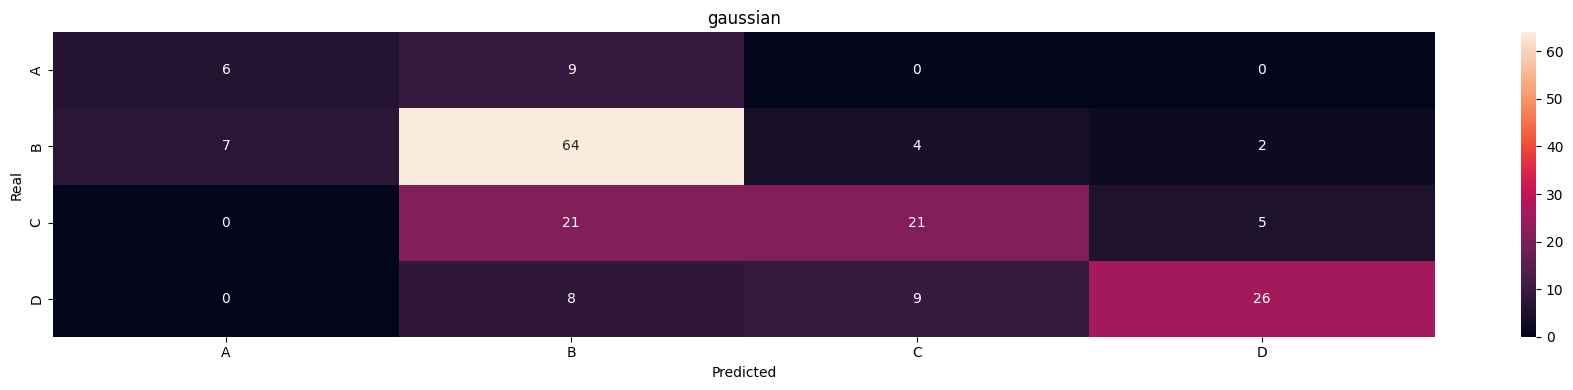

In [120]:
res_og = naive_bayes_fits(results, X_train_3, y_train_1, X_val_2, y_val)

In [121]:
res_og["gaussian"]["model"].predict(X_test_2)

array(['B', 'B', 'D', 'C', 'B', 'C', 'D', 'B', 'B', 'B', 'C', 'C', 'D',
       'D', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'D', 'B', 'D', 'B', 'C',
       'C', 'B', 'B', 'D', 'C', 'B', 'C', 'B', 'B', 'B', 'C', 'B', 'C',
       'B', 'B', 'D', 'D', 'B', 'B', 'C', 'D', 'C', 'B', 'B', 'D', 'B',
       'C', 'C', 'B', 'B', 'B', 'D', 'B', 'A', 'B', 'C', 'B', 'B', 'B',
       'C', 'C', 'C', 'B', 'B', 'D', 'B', 'B', 'D', 'D', 'C', 'D', 'B',
       'C', 'D', 'C', 'C', 'D', 'A', 'B', 'B', 'B', 'B', 'D', 'A', 'B',
       'C', 'A', 'B', 'D', 'D', 'C', 'B', 'C', 'C', 'D', 'A', 'D', 'B',
       'D', 'B', 'B', 'C', 'C', 'B', 'B', 'A', 'D', 'C', 'D', 'C', 'D',
       'D', 'C', 'C', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'D', 'D', 'A',
       'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'D', 'D', 'B', 'D',
       'B', 'B', 'B', 'D', 'B', 'D', 'B', 'C', 'C', 'D', 'C', 'A', 'B',
       'B', 'C', 'B', 'C', 'C', 'D', 'B', 'B', 'C', 'B', 'B', 'D', 'D',
       'B', 'A', 'A', 'B', 'B', 'D', 'C', 'B', 'C', 'D', 'B', 'B

In [87]:
get_kaggle_pred(res_og["gaussian"]["model"], X_test_2, X_test_ids, fname="testing_3")

In [124]:
score = cross_val_score(GaussianNB(), X_train_3, y_train_1)

In [126]:
score.mean()

0.56875

# DISCRETO

In [94]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [136]:
results = {
    # "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

In [137]:
out = naive_bayes_fits(results, X_train, y_train, X_val, y_val)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [135]:
X_train, X_val, X_test = discretize(X_train, X_val, X_test, 30, enconder="onehot-dense", strat="uniform")

/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [67]:
get_kaggle_pred(out["categorical_1"]["model"], X_test, X_test_ids, fname="nb_categorical__raw")

NameError: name 'out' is not defined

In [104]:
out["categorical_1"]["model"]

CategoricalNB(force_alpha=True)

In [106]:

# open a file, where you ant to store the data
file = open('best_categorical.pkl', 'wb')

# dump information to that file
pickle.dump(out["categorical_1"]["model"], file)

# close the file
file.close()

In [ ]:
pickle.dump(out["categorical_1"]["model"])

# Optuna

In [263]:
class TuningParams:
    def __init__(self, X_data, y_data, X_test) -> None:
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_data, 
                                                            y_data, stratify=y_data, 
                                                            test_size=0.2, 
                                                            random_state=16)
        self.X_test = X_test.drop(columns=["ID"])
        self.X_test_ids = X_test["ID"]
        self.trial = {}

        self.scalers = {"std" : StandardScaler(), 
                        "norm" : Normalizer(), 
                        "quan" : QuantileTransformer(n_quantiles=600), 
                        "power" : PowerTransformer()}

    def objective_function(self, trial):
        X_train = self.X_train
        y_train = self.y_train
        X_val   = self.X_val
        y_val   = self.y_val
        X_test  = self.X_test

        # Standarization
        scaler = trial.suggest_categorical("scaler", ["std", "norm", "quan", "power"])
        X_train, X_val, X_test = set_scaler(self.scalers[scaler], X_train, X_val, X_test)

        # LOF
        do_LOF = trial.suggest_categorical("lof", [True, False])

        if(do_LOF):
            neigs = trial.suggest_int("lof_neighs", 10, 30)
            X_train, y_train = get_lof(X_train, y_train, neigs)

        # Feature Selection
        do_feat_sel = trial.suggest_categorical("feature_selection", [True, False])

        if(do_feat_sel):
            sel_type = trial.suggest_categorical("feat_sel_type", ["top", "perc"])

            if(sel_type == "top"):
                trial.set_user_attr("num_cols", len(X_train.columns))
                best_k = trial.suggest_int("top_k", 5, 25)
                X_train, X_val, X_test = feature_top(X_train, y_train, X_val, X_test, best_k)
            else:
                perc = trial.suggest_int("perc", 5, 25)
                X_train, X_val, X_test = feature_perc(X_train, y_train, X_val, X_test, perc)

        # Correlated Columns
        delete_correlated = trial.suggest_categorical("delete_correlated", [True, False])
        if(delete_correlated):
            corr_val = trial.suggest_float("corr_value", 0.5, 0.8)
            X_train, X_val, X_test = delete_corr(X_train, X_val, X_test, corr_val)
        
        # PCA
        do_PCA = trial.suggest_categorical("pca", [True, False])

        if(do_PCA):
            ratio = trial.suggest_float("pca_ratio", 0.5, 0.95)
            X_train, X_val, X_test = set_PCA(X_train, X_val, X_test, ratio)

        # Under/Oversampling
        do_resampling = trial.suggest_categorical("resample", [True, False])

        if(do_resampling):
            kind = trial.suggest_categorical("kind", ["up", "down"])
            if(kind == "up"):
                neigs = trial.suggest_int("up_neighs", 2, 10)
                X_train, y_train = up_sample(X_train, y_train, neigs)
            else:
                neigs = trial.suggest_int("down_neighs", 2, 10)
                X_train, y_train = down_sample(X_train, y_train, neigs)



        all_good = True

        # Fitting and testing...
        nb_type = trial.suggest_categorical("nb_type", ["gauss", "discrete"])
        if(nb_type == "gauss"):
            model = GaussianNB()
        
        if(nb_type == "discrete"):
            discr_bins = trial.suggest_int("discr_bins", 10, 20)
            discr_encoder = trial.suggest_categorical("discr_encoder", ["onehot-dense", "ordinal"])
            discr_strat = trial.suggest_categorical("discr_strat", ["uniform", "quantile"])

            try:
                X_train, X_val, X_test = discretize(X_train, X_val, X_test, discr_bins, discr_encoder, discr_strat)
            except Exception:
                return -1
            
            model = CategoricalNB(force_alpha=True)

        try:
            y_train_pred = model.fit(X_train, y_train).predict(X_train)
            y_val_pred   = model.predict(X_val)
            y_test_pred  = model.predict(X_test)
        except Exception:
            return -1

        self.trial[trial.number] = {}
        self.trial[trial.number]["train_stats"] = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_stats"]   = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        self.trial[trial.number]["val_conf"]    = confusion_matrix(y_val, y_val_pred)
        self.trial[trial.number]["train_pred"]  = y_train_pred
        self.trial[trial.number]["val_pred"]    = y_val_pred
        # self.trial[trial.number]["X_test"]      = X_test
        self.trial[trial.number]["test_pred"]   = y_test_pred
        self.trial[trial.number]["model"]       = model
        
        act_acc = self.trial[trial.number]["val_stats"]["accuracy"]
        act_f1  = self.trial[trial.number]["val_stats"]["macro avg"]["f1-score"]

        fitness = np.mean([act_acc, act_f1])

        self.trial[trial.number]["fitness"] = fitness

        return fitness

    def get_trial_test(self, num_trial):
        return self.trial[num_trial]
    
    def get_k_best_trials(self, study, k=5, save_kaggle=False, show_cf=True, path="."):
        trials = study.best_trials[:k]
        results = {}
        for t in trials:
            act_name = "{}__{}".format(study.study_name, t.number)
            act_result = self.get_trial_test(t.number)
            act_result["params"] = t.params

            results[act_name] = act_result
            if(save_kaggle):
                to_kaggle(act_result["test_pred"], self.X_test_ids, path=path, fname = act_name)

        naive_bayes_stats(results, show_cf=show_cf)
        return results

In [264]:
BNTuning = TuningParams(df_credit_x, df_credit_y, df_test)

In [265]:
study = optuna.create_study(direction="maximize", study_name="tuning__{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

study.optimize(BNTuning.objective_function, n_trials=1000)

[I 2024-01-09 18:26:12,892] A new study created in memory with name: tuning__20240109-182612
[I 2024-01-09 18:26:13,263] Trial 0 finished with value: 0.5770590885856433 and parameters: {'scaler': 'power', 'lof': False, 'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 15, 'delete_correlated': False, 'pca': False, 'resample': False, 'nb_type': 'gauss'}. Best is trial 0 with value: 0.5770590885856433.
[I 2024-01-09 18:26:13,587] Trial 1 finished with value: 0.4450327246283129 and parameters: {'scaler': 'norm', 'lof': False, 'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 22, 'delete_correlated': True, 'corr_value': 0.5704794622590179, 'pca': True, 'pca_ratio': 0.8150523913692737, 'resample': False, 'nb_type': 'discrete', 'discr_bins': 11, 'discr_encoder': 'onehot-dense', 'discr_strat': 'quantile'}. Best is trial 0 with value: 0.5770590885856433.
[I 2024-01-09 18:26:14,062] Trial 2 finished with value: 0.5090724431894437 and parameters: {'scaler': 'power', 'lof': Tru

In [139]:
results = BNTuning.get_trial_test(119)

In [215]:
study.best_params

{'standarize': True,
 'scaler': 'power',
 'lof': True,
 'lof_neighs': 12,
 'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 24,
 'delete_correlated': False,
 'pca': False,
 'resample': False}

In [210]:
study.best_trial.params

{'standarize': True,
 'scaler': 'power',
 'lof': True,
 'lof_neighs': 10,
 'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 17,
 'delete_correlated': False,
 'pca': False,
 'resample': False}

In [224]:
self_trials = BNTuning.trial

In [188]:
BNTuning.trial = self_trials

Variant                         F1 Score    Train Acc    Test Acc  Parameters
----------------------------  ----------  -----------  ----------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tuning__20240109-182612__925      0.6521      67.9558     65.9341  {'scaler': 'quan', 'lof': False, 'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 13, 'delete_correlated': False, 'pca': False, 'resample': False, 'nb_type': 'discrete', 'discr_bins': 16, 'discr_encoder': 'ordinal', 'discr_strat': 'uniform'}
tuning__20240109-182612__926      0.6521      67.9558     65.9341  {'scaler': 'quan', 'lof': False, 'feature_selection': True, 'feat_sel_type': 'top', 'top_k': 13, 'delete_correlated': False, 'pca': False, 'resample': False, 'nb_type': 'discrete', 'discr_bins': 16, 'discr_encoder':

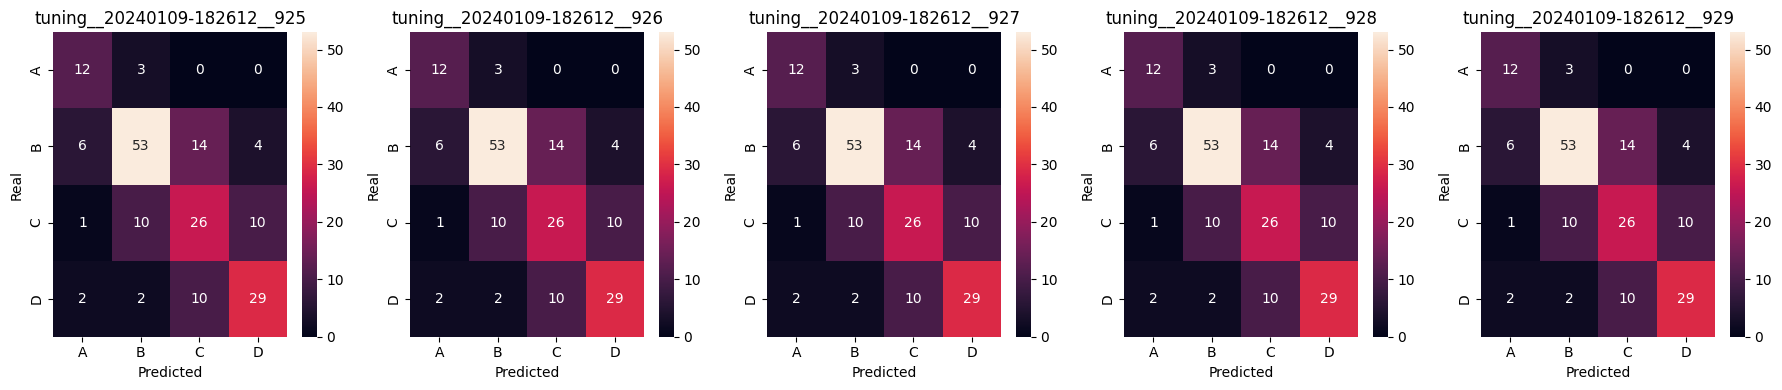

In [266]:
out = BNTuning.get_k_best_trials(study, k=5,save_kaggle=True);

In [219]:
out["tuning__20240109-170403__378"]["params"]

{'standarize': True,
 'scaler': 'power',
 'lof': True,
 'lof_neighs': 12,
 'feature_selection': True,
 'feat_sel_type': 'top',
 'top_k': 24,
 'delete_correlated': False,
 'pca': False,
 'resample': False}

In [267]:
trials = study.trials_dataframe()

In [268]:
trials = trials.sort_values(by=["value"], ascending=False)

In [272]:
t_dict = trials.to_dict()

In [278]:
t_dict.keys()

dict_keys(['number', 'value', 'datetime_start', 'datetime_complete', 'duration', 'params_corr_value', 'params_delete_correlated', 'params_discr_bins', 'params_discr_encoder', 'params_discr_strat', 'params_down_neighs', 'params_feat_sel_type', 'params_feature_selection', 'params_kind', 'params_lof', 'params_lof_neighs', 'params_nb_type', 'params_pca', 'params_pca_ratio', 'params_perc', 'params_resample', 'params_scaler', 'params_top_k', 'params_up_neighs', 'user_attrs_num_cols', 'state'])

Variant      F1 Score    Train Acc    Test Acc
---------  ----------  -----------  ----------
gaussian       0.6580      64.5028     64.2857


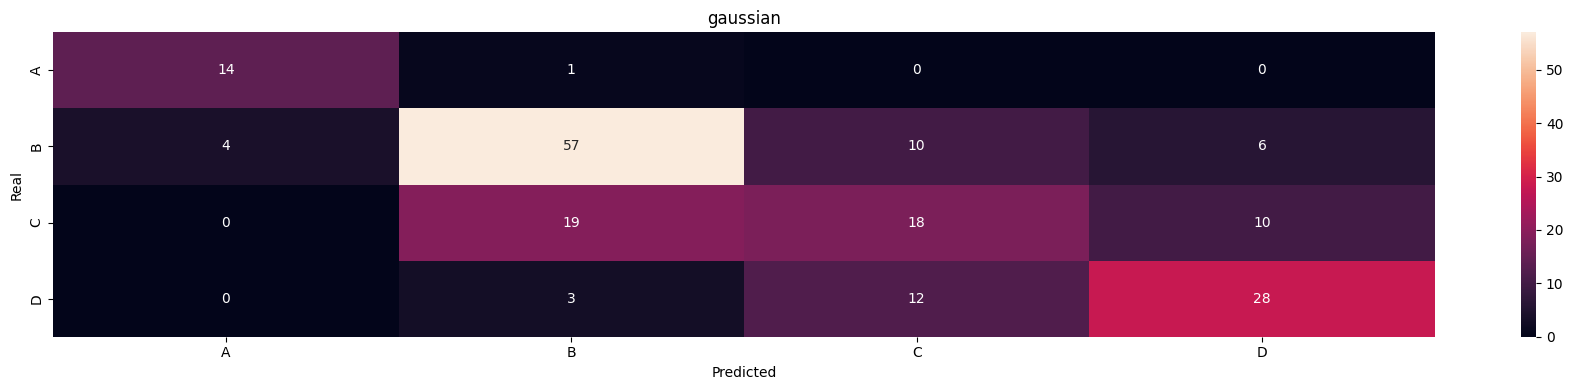

In [140]:
res = {"gaussian" : results}
naive_bayes_stats(res)

In [91]:
res["gaussian"].keys()

dict_keys(['train_stats', 'val_stats', 'val_conf', 'train_pred', 'val_pred', 'test_pred', 'fitness'])

In [155]:
to_kaggle(results["test_pred"], X_test_ids, fname="testing__power")

In [154]:
results["test_pred"]

array(['B', 'B', 'D', 'D', 'B', 'D', 'D', 'C', 'B', 'D', 'D', 'C', 'D',
       'D', 'D', 'B', 'D', 'D', 'B', 'A', 'C', 'D', 'A', 'D', 'B', 'D',
       'B', 'B', 'B', 'D', 'D', 'B', 'C', 'B', 'B', 'B', 'B', 'B', 'D',
       'B', 'C', 'C', 'D', 'C', 'B', 'C', 'D', 'B', 'B', 'C', 'C', 'B',
       'D', 'B', 'B', 'B', 'B', 'D', 'C', 'D', 'C', 'B', 'B', 'C', 'C',
       'D', 'C', 'D', 'B', 'B', 'D', 'B', 'D', 'D', 'C', 'D', 'C', 'B',
       'D', 'D', 'D', 'C', 'D', 'B', 'B', 'B', 'C', 'B', 'A', 'A', 'B',
       'D', 'C', 'B', 'D', 'C', 'D', 'B', 'B', 'C', 'D', 'A', 'D', 'C',
       'D', 'A', 'A', 'C', 'C', 'B', 'C', 'C', 'D', 'D', 'D', 'C', 'D',
       'D', 'D', 'D', 'A', 'B', 'B', 'B', 'B', 'B', 'A', 'D', 'D', 'A',
       'B', 'C', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'D', 'D', 'B', 'C',
       'C', 'B', 'B', 'D', 'B', 'D', 'C', 'B', 'C', 'D', 'D', 'A', 'B',
       'A', 'C', 'B', 'C', 'C', 'D', 'B', 'C', 'C', 'A', 'B', 'D', 'C',
       'C', 'B', 'B', 'B', 'B', 'B', 'C', 'B', 'C', 'D', 'B', 'B

In [111]:
results["model"].predict(results["X_test"])

array(['B', 'B', 'D', 'C', 'B', 'C', 'D', 'B', 'B', 'B', 'C', 'C', 'D',
       'D', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'D', 'B', 'D', 'B', 'C',
       'C', 'B', 'B', 'D', 'C', 'B', 'C', 'B', 'B', 'B', 'C', 'B', 'C',
       'B', 'B', 'D', 'D', 'B', 'B', 'C', 'D', 'C', 'B', 'B', 'D', 'B',
       'C', 'C', 'B', 'B', 'B', 'D', 'B', 'A', 'B', 'C', 'B', 'B', 'B',
       'C', 'C', 'C', 'B', 'B', 'D', 'B', 'B', 'D', 'D', 'C', 'D', 'B',
       'C', 'D', 'C', 'C', 'D', 'A', 'B', 'B', 'B', 'B', 'D', 'A', 'B',
       'C', 'A', 'B', 'D', 'D', 'C', 'B', 'C', 'C', 'D', 'A', 'D', 'B',
       'D', 'B', 'B', 'C', 'C', 'B', 'B', 'A', 'D', 'C', 'D', 'C', 'D',
       'D', 'C', 'C', 'A', 'B', 'C', 'B', 'B', 'B', 'B', 'D', 'D', 'A',
       'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'D', 'D', 'B', 'D',
       'B', 'B', 'B', 'D', 'B', 'D', 'B', 'C', 'C', 'D', 'C', 'A', 'B',
       'B', 'C', 'B', 'C', 'C', 'D', 'B', 'B', 'C', 'B', 'B', 'D', 'D',
       'B', 'A', 'A', 'B', 'B', 'D', 'C', 'B', 'C', 'D', 'B', 'B

In [112]:
results["X_test"]

,0,1,2,3,4,5,6,7
0,-2.468967,0.922614,0.089367,0.565720,0.297337,0.978705,-0.057186,0.055731
1,-0.517422,0.858148,0.973429,-0.529261,1.203458,0.446066,0.749932,0.030013
2,1.557921,-0.509113,4.037219,-0.972139,-1.100319,-1.175198,1.487040,-0.268686
3,2.534783,-0.354601,0.468763,-0.024231,-0.307189,0.124881,0.337072,0.064585
4,-1.119715,-0.944308,0.419007,-1.283374,0.019552,-0.581999,-0.842523,-1.277957
...,...,...,...,...,...,...,...,...
384,-3.167863,-0.437934,-0.513369,0.579227,-3.084633,2.326840,-0.382735,3.093267
385,2.912082,0.510535,-0.186255,0.093206,1.107413,0.962007,-0.150436,0.566399
386,3.872915,-2.303260,-0.785760,-0.506762,-0.569761,1.045076,0.536323,0.096883
387,-1.632839,-0.191870,-0.222974,0.467786,0.662087,0.408631,-0.189576,-0.308743
